# Capstone Project 1: Data Wrangling

**Our Problem:** 

Can emails be used to identify the author's gender?

## Overview
This notebook will use text-based binary classification on email body text to predict a sender's gender.  We'll do this in 4 sections:
- Acquiring our data;
- Cleaning our data;
- Feature selection; and,
- Model implementation;

Throughout these exercises, we will use exploratory data analysis, **EDA**, to gain insight into the data and frame decision-making. Finally, statistical observations will be used to aid in forming insight regarding the data.

# I. Acquiring the Data
The data we'll be working with comes in two forms:
- The Enron email dataset
- Assumed gender by name

The Enron email dataset we'll be working with can be downloaded online from the Carnegie Mellon University School of Computer Science (https://www.cs.cmu.edu/~./enron/) as of March 28, 2020. It comes convieniently zipped under the filename `enron_mail_20150507.tar.gz`.

To collect the assumed genders, by name, we'll need to isolate the sender names and decide on a method of identifying gender. We'll return to this once the dataset is cleaned.

### Acquiring the Data: Enron Emails

Once unzipped, the initial file is `maildir`; we'll call this the *mail directory* (I know - creative). The hierarchy in this file directory goes as such:
- Mail Directory ('maildir')
 - Employee Email Folders
  - disorganized mess (folders + emails)

Let's use the `os` library to explore the directory with its function `os.scandir()`. We'll evaluate each object returned by `os.scandir()`; if it is another folder, we'll `.append()` it to our list so it will also get explored.

Once all the folders have been collected, the second part of the function will iterate through the complete `folder_list` and compile a `file_list` of email file names.

In [ ]:
import os

# setup function to return filenames from directory
def file_grabber(some_directory):
    """Returns all files from directory
    and child directories by creating, appending
    a directory list until all directories are located.
    
    Then, cycles through each directory and records any
    filenames to a list. This list is returned on completion."""
    
    # initialize folder list
    folder_list = []

    # appends starting folder to folder list
    folder_list.append(some_directory)
    
    # iterate through folder list
    for folder in folder_list:
        
        # open content manager with .scandir() on folder
        with os.scandir(folder) as open_folder:

            # for each item in the directory folder
            for thing in open_folder:

                # if the thing is another folder
                if thing.is_dir():
                    thing_path = (folder + thing.name + '/')
                    folder_list.append(thing_path)
                else:
                    continue
      
    # print out number of folders
    print('{} folders found.'.format(len(folder_list)))
    
    # initialize file list
    file_list = []
    
    # iterate through folder list to collect filenames
    for folder in folder_list:
        
        # open content manager with .scandir() on folder
        with os.scandir(folder) as open_folder:

            # for each item in the directory folder
            for thing in open_folder:

                # if the thing is another folder
                if thing.is_file():
                    thing_path = (folder + thing.name)
                    file_list.append(thing_path)
                else:
                    continue
                
    # print out report                    
    print('{} files found.'.format(len(file_list)))
    
    # return files as list
    return file_list

***Function complete.*** Now, let's put it into action!

In [2]:
# initialize list to collect filenames
email_files = []

# create base string
base_name = './data/maildir/'
    
# call function to collect file names
email_files = file_grabber(base_name)

3500 folders found.
517401 files found.


***Nice!*** 517401 files found! Let's sort the list and look at some of the filepaths returned.

In [3]:
# sort the list
email_files.sort()

# take a peek
email_files[:5]

['./data/maildir/allen-p/_sent_mail/1',
 './data/maildir/allen-p/_sent_mail/10',
 './data/maildir/allen-p/_sent_mail/100',
 './data/maildir/allen-p/_sent_mail/1000',
 './data/maildir/allen-p/_sent_mail/1001']

## Wrangling the Data

> Data Wrangling:
>
> "The process of transforming and mapping data from one "raw" data form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes such as **analytics**." - Wikipedia, Data wrangling

Let's begin by exploring the *current state of the data*. We'll make notes, and decide what ***wrangling*** we'll need to do. 

The dataset itself is over 0.5M emails, comes as a *bunch of folders* containing a **bunch of emails** and the unzipped form we'll be working with weighs in around 1.4GB. Let's review an email and isolate some parts to wrangle.

In [4]:
# email reader
def read_email(email_path):
    """returns email body as a body of text"""
    
    # file manager opens email file, assigns it to variable
    with open(email_path) as email_file:
        email_body = email_file.read()
    
    # returns email body as text
    return email_body

In [5]:
# email text by line as list
print(read_email(email_files[10]))

Message-ID: <33076797.1075855687515.JavaMail.evans@thyme>
Date: Mon, 16 Oct 2000 06:42:00 -0700 (PDT)
From: phillip.allen@enron.com
To: buck.buckner@honeywell.com
Subject: Re: FW: fixed forward or other Collar floor gas price terms
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: "Buckner, Buck" <buck.buckner@honeywell.com> @ ENRON
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

Mr. Buckner,

 For delivered gas behind San Diego, Enron Energy Services is the appropriate 
Enron entity.  I have forwarded your request to Zarin Imam at EES.  Her phone 
number is 713-853-7107.  

Phillip Allen


### ***To evaluate our problem,*** we need gender and email text.

From the email above, we'll collect the `From:` fields to return names from email addresses. Also, we'll need to isolate the email body.    

We'll accomplish this using regular expressions, also known as **re, regex,** and other names. Regex occur across multiple programming languages and are useful especially in text analysis because they provide a means of interacting with text data through the use of ***pattern matching***. 

Let's tackle this goal in two steps:
- Collect the variables of interest in a dictionary using the `regex` library
- Convert the dictionary to a DataFrame using `pd.DataFrame.from_dict()`

> We're using the `regex` library (vers 2.5.80) because it builds on the standard python library; while its additional functionality isn't explored greatly in this exercise, one of the boons of the `regex` library is its improved *lookback* functionality. 

In [6]:
# libraries
import regex as re

# custom function
def save_to_dict(email_path):
    """create dictionary from a list of filepath files
       returns dictionary"""

    # open email file, get email text
    with open(email_path) as open_email:
        
        # get file text
        email_text = open_email.read()
        
        # get 'Message-ID'
        m_id = ''
        catch = m_id_pat.search(email_text)
        if catch:
            m_id = catch[0]         
    
        # get 'Date'
        m_date = ''
        catch = m_date_pat.search(email_text)
        if catch:
            m_date = catch[0]     
        
        # get 'From'
        m_from = ''
        catch = m_from_pat.search(email_text)
        if catch:
            m_from = catch[0] 
        
        # get 'To'
        m_to = ''
        catch = m_to_pat.search(email_text)
        if catch:
            m_to = catch[0] 

        # get 'Cc'
        m_cc = ''
        catch = m_cc_pat.search(email_text)
        if catch:
            m_cc = catch[0] 
        
        # get 'Bcc'
        m_bcc = ''
        catch = m_bcc_pat.search(email_text)
        if catch:
            m_bcc = catch[0] 

        # get 'Subject'
        m_subj = ''
        catch = m_subj_pat.search(email_text)
        if catch:
            m_subj = catch[0] 

        # get 'Mime-Version'
        mime_vers = ''
        catch = mime_vers_pat.search(email_text)
        if catch:
            mime_vers = catch[0] 

            # get 'Content-Type'
        cont_type = ''
        catch = cont_type_pat.search(email_text)
        if catch:
            cont_type = catch[0] 

        # get 'Content-Transfer-Encoding'
        encode = ''
        catch = encode_pat.search(email_text)
        if catch:
            encode = catch[0] 

        # get 'X-From'
        x_from = ''
        catch = x_from_pat.search(email_text)
        if catch:
            x_from = catch[0] 

        # get 'X-To'
        x_to = ''
        catch = x_to_pat.search(email_text)
        if catch:
            x_to = catch[0] 

        # get 'X-cc'
        x_cc = ''
        catch = x_cc_pat.search(email_text)
        if catch:
            x_cc = catch[0] 

        # get 'X-bcc'
        x_bcc = ''
        catch = x_bcc_pat.search(email_text)
        if catch:
            x_bcc = catch[0] 

        # get 'X-Folder'
        x_fold = ''
        catch = x_fold_pat.search(email_text)
        if catch:
            x_fold = catch[0] 

        # get 'X-Origin'
        x_orig = ''
        catch = x_orig_pat.search(email_text)
        if catch:
            x_orig = catch[0] 

        # get 'X-Filename'
        x_fname = ''
        catch = x_fname_pat.search(email_text)
        if catch:
            x_fname = catch[0]
    
        # get body
        m_body = ''
        catch = m_body_pat.split(email_text, 1)
        if catch:
            m_body = catch[1]
        
        # create dictionary entry
        wrangle_dict[email_path] = [m_id, m_date, m_from, m_to, 
                                    m_cc, m_bcc, m_subj, mime_vers, 
                                    cont_type, encode, x_from, x_to, 
                                    x_cc, x_bcc, x_fold, x_orig, 
                                    x_fname, m_body]

In [7]:
%%time
# import re library
import re
import concurrent.futures

# set regex patterns 'Message-ID'
m_id_pat = re.compile('(?<=Message-ID: )[^\n]*')

# set regex patterns 'Date'
m_date_pat = re.compile('(?<=\nDate: )[^\n]*')
    
# set regex patterns 'From'
m_from_pat = re.compile('(?<=\nFrom: )[^\n]*')

# set regex patterns 'To'
m_to_pat = re.compile('(?<=\nTo: )[^\n]*')

# set regex patterns 'Cc'
m_cc_pat = re.compile('(?<=\nCc: )[^\n]*')

# set regex patterns 'Bcc'
m_bcc_pat = re.compile('(?<=\nBcc: )[^\n]*')

# set regex patterns 'Subject'
m_subj_pat = re.compile('(?<=\nSubject: )[^\n]*')

# set regex patterns 'Mime-Version'
mime_vers_pat = re.compile('(?<=\nMime-Version: )[^\n]*')

# set regex patterns 'Content-Type'
cont_type_pat = re.compile('(?<=\nContent-Type: )[^\n]*')

# set regex patterns 'Content-Transfer-Encoding'
encode_pat = re.compile('(?<=\nContent-Transfer-Encoding: )[^\n]*')

# set regex patterns 'X-From'
x_from_pat = re.compile('(?<=\nX-From: )[^\n]*')

# set regex patterns 'X-To'
x_to_pat = re.compile('(?<=\nX-To: )[^\n]*')

# set regex patterns 'X-cc'
x_cc_pat = re.compile('(?<=\nX-cc: )[^\n]*')

# set regex patterns 'X-bcc'
x_bcc_pat = re.compile('(?<=\nX-bcc: )[^\n]*')

# set regex patterns 'X-Folder'
x_fold_pat = re.compile('(?<=\nX-Folder: )[^\n]*')

# set regex patterns 'X-Origin'
x_orig_pat = re.compile('(?<=\nX-Origin: )[^\n]*')

# set regex to return X-Filename, email body
x_fname_pat = re.compile('(?<=\nX-FileName: )[^\n]*\n\n')

# set regex patterns 'Body'
m_body_pat = re.compile('\nX-FileName: [^\n]*\n\n')

# initialize dictionary
wrangle_dict = {}

# concurrent futures executor
with concurrent.futures.ThreadPoolExecutor() as executor:  
    future = executor.map(save_to_dict, email_files)


Wall time: 5min 33s


In [8]:
len(wrangle_dict)

517401

In [429]:
%%time
# import pandas
import pandas as pd

# create dataframe from dictionary
wrangle_frame = pd.DataFrame.from_dict(wrangle_dict, orient='index', columns = ['m_id', 'm_date', 'm_from', 'm_to', 
                                                                                'm_cc', 'm_bcc', 'm_subj', 'mime_vers', 
                                                                                'cont_type', 'encode', 'x_from', 'x_to', 
                                                                                'x_cc', 'x_bcc', 'x_fold', 'x_orig', 
                                                                                'x_fname', 'm_body'])

# sort file directory names, pop it out to column
wrangle_frame = wrangle_frame.sort_index().reset_index()

# rename index column 'f_dir'
wrangle_frame = wrangle_frame.rename(columns = {'index' : 'f_dir'})

# export master to csv
wrangle_frame.to_csv('./data/00_original_wrangle.csv', index=False, index_label=False)

# check DataFrame
wrangle_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 19 columns):
f_dir        517401 non-null object
m_id         517401 non-null object
m_date       517401 non-null object
m_from       517401 non-null object
m_to         517401 non-null object
m_cc         517401 non-null object
m_bcc        517401 non-null object
m_subj       517401 non-null object
mime_vers    517401 non-null object
cont_type    517401 non-null object
encode       517401 non-null object
x_from       517401 non-null object
x_to         517401 non-null object
x_cc         517401 non-null object
x_bcc        517401 non-null object
x_fold       517401 non-null object
x_orig       517401 non-null object
x_fname      517401 non-null object
m_body       517401 non-null object
dtypes: object(19)
memory usage: 75.0+ MB
Wall time: 29.9 s


## Getting gender from names
The entire process used to retrieve the gender was split into two activities:
- Passing names retrieved from emails to an online web query and scraping results; and,
- Cross-referencing names retrieved from emails with the *1991 Mark Kantrowitz Names Corpus* downloaded with permission from NLTK;

Below is an example of the `regex` patterns used to recover names from the sender email addresses; also are a reference to the names corpus and a glimpse at the *'gender key'* before it was merged back into the dataframe and used for our target variable for this project.

The full process is not included here, but can be found in the associated notebook `01_getting_gender.ipynb`.

In [6]:
def clean_m_from(s):
    """Use this to recover names from the email addresses
       with regular expression captures. 8 cases are outlined
       below for capture. A final case (ZZ) wipes the cell.
       
       Wiped cell will be used to consider value fills from
       strings recovered from the X-From column."""
    #
    # cleans email addresses for the following cases, returning a string to place in a subsequent (name) column.
    # the following notation is used to explain cases:
    #     fname = first name
    #     lname = last name
    #     mname = middle name
    #     init = initial
    #     ffname = another word considered with first name
    #     scotts = name string contains an apostrophe
    #
    # CASE 01: fname'.lname'@enron.com (fname lname)
    # CASE 02: string@enron.com (string)
    # CASE 03: finit..lname@enron.com or finit.lname@enron.com (finit lname)
    # CASE 04: fname.minit.lname@enron.com (fname lname)
    # CASE 05: fname-ffname.lname@enron.com (fname-ffname lname)
    # CASE 06: fname.lname.enronxgate@enron.com (fname lname)
    # CASE 07: fname_lname@enron.com (fname lname)
    # CASE 08: fname.lname-llname@enron.com (fname lname-llname)
    # CASE ZZ [CREATE NULL]: @enron.com ('')
    # 

    try:

        # CASE 01
        p = '^([A-Za-z\']+)[.]([A-Za-z\']+)@enron.com$'
        if re.search(p, s):
            s = re.search(p, s)
            s = (s[1]+' '+s[2]) # (fname lname)
                
        # CASE 02
        p = '^([A-Za-z]+)@enron.com$'
        if re.search(p, s):
            s = re.search(p, s)
            s = (s[1]) # (string)
                    
        # CASE 03
        p = '^([A-Za-z])[.]{1,2}([A-Za-z]+)@enron.com$'
        if re.search(p, s):
            s = re.search(p, s)
            s = (s[1]+' '+s[2]) # (finit lname)

        # CASE 04
        p = '^([A-Za-z]+)[.][A-Za-z][.]([A-Za-z]+)@enron.com$'
        if re.search(p, s):
            s = re.search(p, s)
            s = (s[1]+' '+s[2]) # (fname lname)
            
        # CASE 05
        p = '^([A-Za-z]+[-][A-Za-z]+)[.]([A-Za-z]+)@enron.com$'
        if re.search(p, s):
            s = re.search(p, s)
            s = (s[1]+' '+s[2]) # (fname-ffname lname)
            
        # CASE 06
        p = '^([A-Za-z]+)[.]([A-Za-z]+).enronxgate@enron.com$'
        if re.search(p, s):
            s = re.search(p, s)
            s = (s[1]+' '+s[2]) # (fname lname)
        
        # CASE 07
        p = '^([A-Za-z\']+)[_]([A-Za-z\']+)@enron.com$'
        if re.search(p, s):
            s = re.search(p, s)
            s = (s[1]+' '+s[2]) # (fname lname)
        
        # CASE 08
        p = '^([A-Za-z]+)[.]([A-Za-z]+[-][A-Za-z]+)@enron.com$'
        if re.search(p, s):
            s = re.search(p, s)
            s = (s[1]+' '+s[2]) # (fname lname)

        # CASE R02
        p = '^[A-Za-z] [A-Za-z\'-]+$'
        if re.search(p, s):
            s = ''

        # CASE R01
        buzz_words = ['team', 'technology', 'security', 'enron', 'chairman', 'office', 'announcement', 'wizard', 'notice', 'address', 'hr taylor', 'coo jeff', 'infrastructure', 'ubsw', 'europe',
                      'human', 'resources', 'connection', 'ibuyit', 'users', 'livelink', 'registrar', 'global', 'business', 'compensation', 'executive', 'risk', 'analytics', 'daemon', 'information',
                      'management', 'helpdesk', 'project', 'sunrise', 'oncall', 'credit', 'union', 'notification', 'central', 'communication', 'center', 'parking', 'transportation', 'international',
                      'diversity', 'survey', 'automation', 'document', 'exec', 'iscinfra', 'public', 'relations', 'controls', 'exchange', 'cms router', 'hotline', 'admin', 'pr id', 'expertfinder',
                      'notes', 'the buzz', 'gpg dss', 'xi xi', 'enw piper', 'institute', 'agent', 'tarrif']
                      
        for word in buzz_words:
            if re.search(word, s):
                s = ''
        
        # CASE ZZ
        p = '^[A-Za-z\'-]+ [A-Za-z\'-]+$'
        if re.search(p, s):
            s
        else:
            s = ''

        return(s)
    
    except:
        
        print('EXCEPTION RETURN: ' + s)
        return(s)

### Import nltk names lists

In [22]:
female_names = pd.read_csv('./data/names/female.txt', sep='\n', header=None)
male_names = pd.read_csv('./data/names/male.txt', sep='\n', header=None)

Names Corpus, Version 1.3 (1994-03-29)
Copyright (C) 1991 Mark Kantrowitz

### Gender key

In [101]:
master_key

m_from gender
0                               phillip.allen@enron.com    boy
1                                  ina.rangel@enron.com   girl
2               1.11913372.-2@multexinvestornetwork.com    NaN
3                            rebecca.cantrell@enron.com   girl
4                                paul.kaufman@enron.com    boy
...                                                 ...    ...
9147                                 emma.vine@gvsi.com   girl
9148                          ben.sturgeon@gfinet.co.uk    boy
9149  6.1132.6c-af5ssclxjfagjsrr.1@mail3.travelocity...    NaN
9150                              megan.scott@enron.com   girl
9151                                    ingjald@shaw.ca    boy

[9152 rows x 2 columns]

In [106]:
gender_df.groupby(['gender']).size()

gender
boy     235804
girl    174119
dtype: int64

## Data Story
Now that the data has been acquired, next will be ***data cleaning.*** Before we start cleaning, it'll be a good idea to look at a few quick visual insights to better understand our data. For brevity, this section will also include some relevant insights collected during feature selection and the modeling workflow.

### Emails sent by gender
Since we're working with **binary** data, or data *that has two **target** variables or **labels**,* it is important to look at their ratio - imbalanced data can lead to misrepresentation when modeling. Significantly unequal data can lead to an **Imbalanced Classification Problem** - where the model will return higher accuracy scores as a result of the overwhelming influence from the larger data Feature or Variable.
> When a dataset is significantly unbalanced, it is useful to rely on **model evaluation metrics** like **precision and recall** because *they consider relevance (i.e. false negatives, positives);* allowing them to be more robust than accuracy when a dataset is unbalanced.
>
> Note: *depending on which field of study,* recall is also referred to as ***sensitivity***.

Throughout this project, our boy-girl ratio sits around 1.3 to 1.4 (i.e. roughly 55/45% boy/girl with ~3% variance observed). We'll consider this balanced and leverage **accuracy** for our initial observations.

gender
boy     90037
girl    68731
dtype: int64


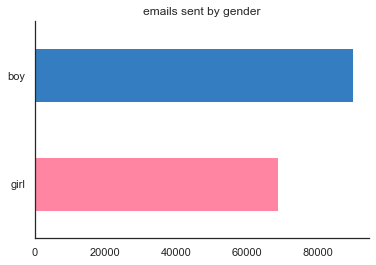

In [12]:
p = df.copy()
p = p.groupby(['gender']).size() # return size agg for gender

one_axis_bar(p, 'emails sent by gender')

### Number of senders by gender

gender
boy     3277
girl    2594
dtype: int64


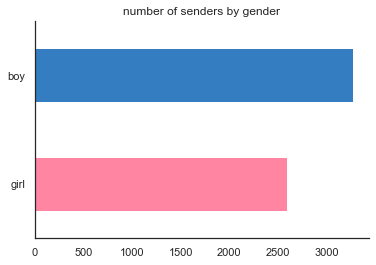

In [13]:
p = df.copy()
p = p.drop_duplicates('m_from').groupby(['gender']).size()

one_axis_bar(p, 'number of senders by gender')

### Emails sent each weekday

day_names
Sunday        3007
Monday       32120
Tuesday      33830
Wednesday    32375
Thursday     29855
Friday       25575
Saturday      1645
Name: 0, dtype: int64


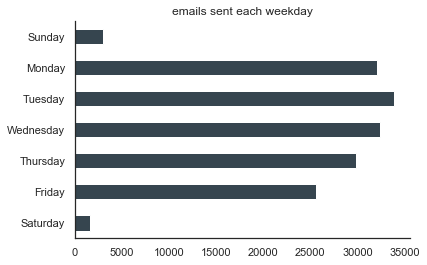

In [16]:
p = timf.loc['1998':].copy() # copy df
p = pd.DataFrame(p.groupby(['day_names']).size())[0].sort_index()  # groupby size, reindex

one_axis_barh(p, 'emails sent each weekday') # send to plotter

### Emails sent each weekday by gender

gender       boy   girl
day_names              
Sunday      2209    798
Monday     18166  13954
Tuesday    18698  15132
Wednesday  18293  14082
Thursday   16878  12977
Friday     14292  11283
Saturday    1249    396


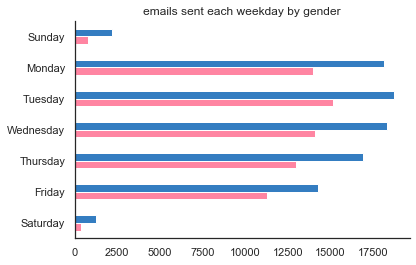

In [17]:
p = timf.loc['1998':].copy() # copy df
p = pd.DataFrame(p.groupby(['day_names', 'gender']).size()).unstack().reindex(labels=daylist)[0]

two_axes_barh(p, 'emails sent each weekday by gender')

gender          boy      girl
day_names                    
Sunday     0.024603  0.011629
Monday     0.202328  0.203346
Tuesday    0.208253  0.220512
Wednesday  0.203742  0.205211
Thursday   0.187982  0.189108
Friday     0.159180  0.164422
Saturday   0.013911  0.005771


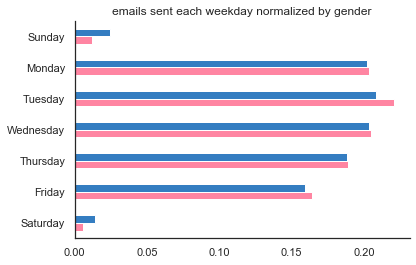

In [18]:
# correcting for 1979 date error
p = timf.loc['1998':].copy() # copy df
gender_totals = p[['gender']] # isolate gender for aggregate
gender_totals = gender_totals.groupby(['gender']).size().reset_index()

p = p.groupby(['day_names', 'gender']).size().reset_index() 
p = p.merge(gender_totals, how='left', on='gender')
p['normalized_gender'] = p['0_x'] / p['0_y'] # create new column of normalized gender counts
p = p.loc[:,['day_names', 'gender', 'normalized_gender']].set_index(['day_names', 'gender']).unstack('gender').normalized_gender # setup dataset 

two_axes_barh(p, 'emails sent each weekday normalized by gender')

### Emails sent each day by gender (normalized)

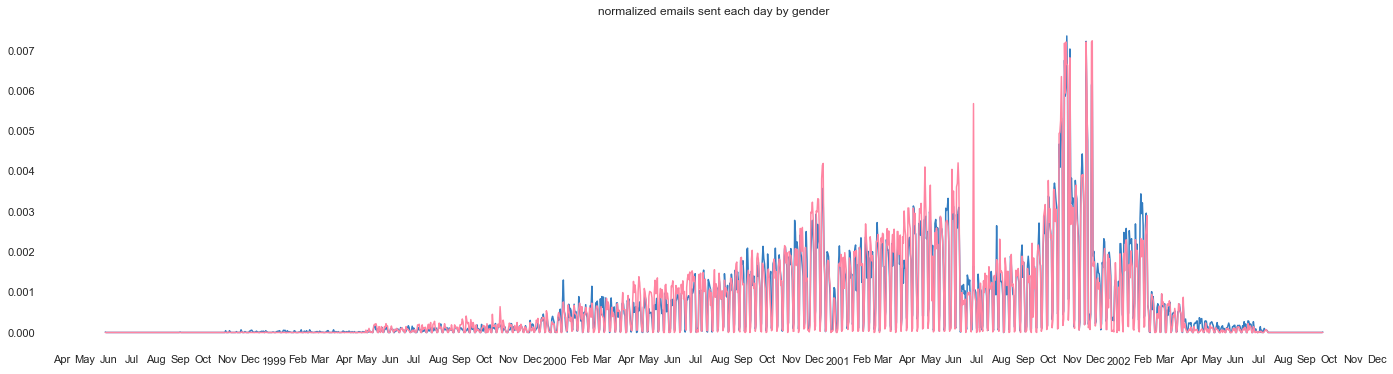

In [24]:
two_var_timeline(p, 'normalized emails sent each day by gender')

### Emails sent each day, interactive

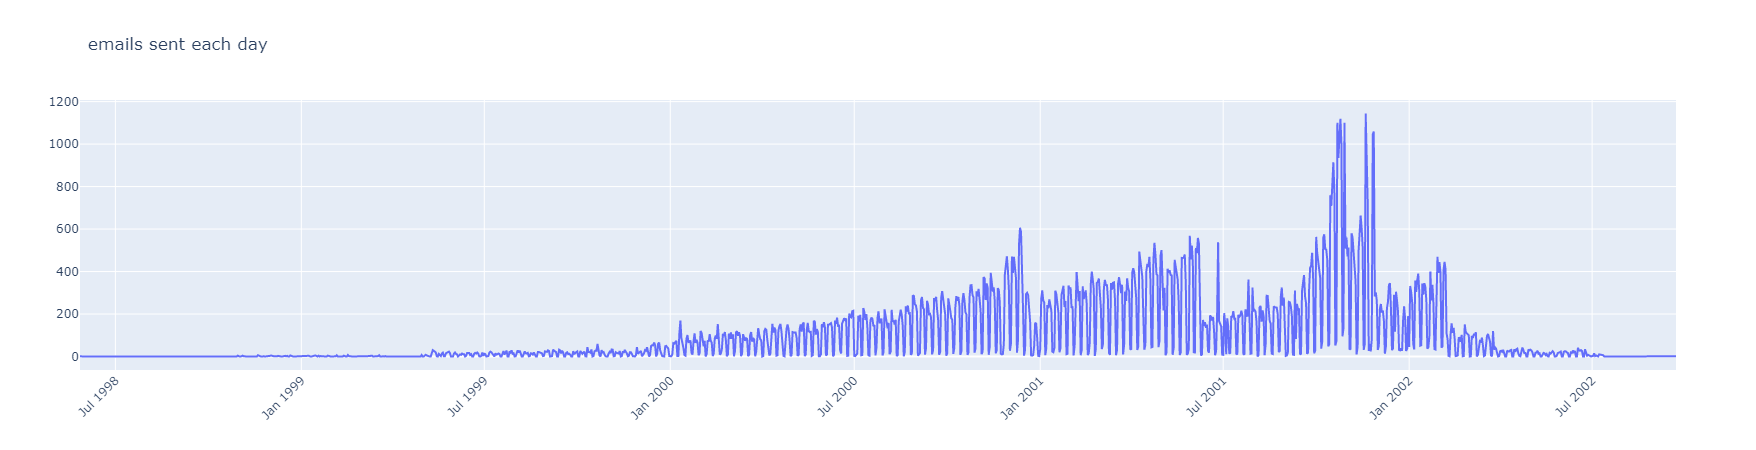

In [20]:
one_in_py_tmline(p, 'emails sent each day')

> As seen in the time series plots above, there are some interesting changes in sent rates around July 2001, and again later that year.
> 
> Significant change could provide insight into a significant event, or highlight issues with the data (Missing, misprint, etc).

# II. Cleaning the data
To clean the data, we'll focus on two primary stages:
- ***Preprocessing,*** or applying functions to the data to assist with processing it;
- ***Filtering,*** or removing duplicates, null values, values extremes, etc;

## Preprocessing the data
As we have seen (And know first-hand), email body text can contain any combination and number of characters, words, and other data objects like images, music, etc. While the Enron email dataset has had the attachments removed from public access, we still have a diverse set of emails that we wish to input into our Machine Learning models.    
    
If every email contained *only* unique features, it would be very hard to classify them together. Likewise, if all emails had the exact same text, it's unlikely we could place them in distinct categories. This is one manifestation of a more abstract ***problem of bias and variance.***

For this assignment, we will be using `regex` for a majority of the character processing. To tokenize and *lemmatize* the words (Or, morphing words into their base forms: the **lemma**), we'll use the NLTK library (vers 3.4.5).
> Depending on what machine learning library we are using, we might be able to leverage the build-in functionality for improved processing. For now, we'll complete these preprocessing steps, 'by hand,' with `regex` and NLTK employed in user functions - but later we'll leverage the optimized functionality of `Sklearn` when applying filters to our dataset.

**Our preprocessing steps are:**
- Remove non-word characters with `regex`
- Remove the underscore character
- Remove single characters
- Remove numbers
- Lowercase all characters
- Reduce multiple spaces to one space
- Lemmatize words with NLTK
> The *underscore* character is considered a word character in the current `regex` version. However, instances of long strings of underscores were discovered during data exploration ("\_______________________________" etc) so we're going to take them out.
> 
> ***Some preprocessing approaches will convert numbers to their word forms.*** The decision to remove numbers for this project was based on removing the influence of dates, phone numbers, or other numerical data that isn't immediately related to sender's gender.
> 

In [1]:
import pandas as pd

In [2]:
gender_frame = pd.read_csv('./data/enron/01_got_gender.csv', index_col=0)

In [3]:
gender_frame.head()

f_dir  \
0     ./data/maildir/allen-p/_sent_mail/1   
1    ./data/maildir/allen-p/_sent_mail/10   
2   ./data/maildir/allen-p/_sent_mail/100   
3  ./data/maildir/allen-p/_sent_mail/1000   
4  ./data/maildir/allen-p/_sent_mail/1001   

                                            m_id  \
0  <18782981.1075855378110.JavaMail.evans@thyme>   
1  <15464986.1075855378456.JavaMail.evans@thyme>   
2  <24216240.1075855687451.JavaMail.evans@thyme>   
3  <13505866.1075863688222.JavaMail.evans@thyme>   
4  <30922949.1075863688243.JavaMail.evans@thyme>   

                                  m_date                   m_from  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  phillip.allen@enron.com   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  phillip.allen@enron.com   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  phillip.allen@enron.com   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  phillip.allen@enron.com   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  phillip.allen@enron.com   

                      m_to m_cc m_bcc     m_subj  mime_vers  \
0     tim.belden@enron.com  NaN   NaN        NaN        1.0   
1  john.lavorato@enron.com  NaN   NaN        Re:        1.0   
2   leah.arsdall@enron.com  NaN   NaN   Re: test        1.0   
3    randall.gay@enron.com  NaN   NaN        NaN        1.0   
4     greg.piper@enron.com  NaN   NaN  Re: Hello        1.0   

                      cont_type encode           x_from  \
0  text/plain; charset=us-ascii   7bit  Phillip K Allen   
1  text/plain; charset=us-ascii   7bit  Phillip K Allen   
2  text/plain; charset=us-ascii   7bit  Phillip K Allen   
3  text/plain; charset=us-ascii   7bit  Phillip K Allen   
4  text/plain; charset=us-ascii   7bit  Phillip K Allen   

                                                x_to x_cc x_bcc  \
0           Tim Belden <Tim Belden/Enron@EnronXGate>  NaN   NaN   
1  John J Lavorato <John J Lavorato/ENRON@enronXg...  NaN   NaN   
2                                   Leah Van Arsdall  NaN   NaN   
3                                      Randall L Gay  NaN   NaN   
4                                         Greg Piper  NaN   NaN   

                                              x_fold   x_orig  \
0  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  Allen-P   
1  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  Allen-P   
2    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   
3    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   
4    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   

                           x_fname  \
0  pallen (Non-Privileged).pst\n\n   
1  pallen (Non-Privileged).pst\n\n   
2                   pallen.nsf\n\n   
3                   pallen.nsf\n\n   
4                   pallen.nsf\n\n   

                                              m_body gender  
0                          Here is our forecast\n\n     boy  
1  Traveling to have a business meeting takes the...    boy  
2                     test successful.  way to go!!!    boy  
3  Randy,\n\n Can you send me a schedule of the s...    boy  
4                Let's shoot for Tuesday at 11:45.      boy

In [4]:
# get features (m_body), target (gender)
df = gender_frame[['m_body', 'gender']].copy()

In [5]:
df.head()

m_body gender
0                          Here is our forecast\n\n     boy
1  Traveling to have a business meeting takes the...    boy
2                     test successful.  way to go!!!    boy
3  Randy,\n\n Can you send me a schedule of the s...    boy
4                Let's shoot for Tuesday at 11:45.      boy

In [6]:
# return the largest email body for preprocessing setup
ts = df.m_body.max()
tss = df.loc[0:20, 'm_body']

In [7]:
tss

0                             Here is our forecast\n\n 
1     Traveling to have a business meeting takes the...
2                        test successful.  way to go!!!
3     Randy,\n\n Can you send me a schedule of the s...
4                   Let's shoot for Tuesday at 11:45.  
5     Greg,\n\n How about either next Tuesday or Thu...
6     Please cc the following distribution list with...
7                      any morning between 10 and 11:30
8     1. login:  pallen pw: ke9davis\n\n I don't thi...
9     ---------------------- Forwarded by Phillip K ...
10    Mr. Buckner,\n\n For delivered gas behind San ...
11    Lucy,\n\n Here are the rentrolls:\n\n\n\n Open...
12    ---------------------- Forwarded by Phillip K ...
13    ---------------------- Forwarded by Phillip K ...
14    Dave, \n\n Here are the names of the west desk...
15             Paula,\n\n 35 million is fine\n\nPhillip
16    ---------------------- Forwarded by Phillip K ...
17    Tim,\n\nmike grigsby is having problems wi

In [11]:
# import regex
import regex as re

# import lemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize # creates tokenized words
from nltk.corpus import stopwords


# instantiate stemmer object
stemmer = WordNetLemmatizer()

# catch list
results = []

def process_text(ts):
    ts = re.sub(r'\W', ' ', str(ts)) # remove characters that are not word characters
    ts = re.sub(r'_+', ' ', str(ts), flags=re.I) # removes the underscore character
    ts = re.sub(r'\s+[a-zA-Z]\s+|\^[a-zA-Z]\s+', ' ', str(ts)) # removes all single characters
    ts = re.sub(r'\d', ' ', str(ts)) # removes numbers
    ts = ts.lower()
    ts = re.sub(r'\s+', ' ', str(ts), flags=re.I) # reduces multiple spaces to single space
    
    # lemmatization
    words = word_tokenize(ts)
    ts = [stemmer.lemmatize(word) for word in words]
    ts = ' '.join(ts)
    
    return ts

In [17]:
%%time
df['p_body'] = df.m_body.apply(process_text)
processed_body = df.copy()
processed_body = processed_body.drop('m_body', axis=1)
processed_body.to_csv('./data/enron/02_preprocessed_body.csv')

Wall time: 29min 45s


## Filtering data
In this project, primary filtering focuses include:
- General NaN occurence across Feature(emails) and Target(gender) variables; and,
- Duplicates

> We'll also introduce some more data filters during feature selection to remove extremes across the dataset.

In [1]:
# import pandas
import pandas as pd
# viewing options
pd.set_option('max_colwidth', 100)

In [2]:
%%time
# import dataframe, drop duplicates
df = pd.read_csv('./data/enron/03_processed_body.csv', index_col=0)
df.groupby(['gender']).size()

Wall time: 6.71 s


gender
boy     235804
girl    174119
dtype: int64

### Monitoring impact on label
We want to keep an eye on the male/female ratio when filtering out our dataset (especially when blanket removing things like 'duplicates', where the filtering can be applied to either label for the same condition) so that our label ratio isn't significantly unbalanced as a result.

In [3]:
def monitor_label(df):
    b = df.groupby(['gender']).size().boy
    g = df.groupby(['gender']).size().girl
    print('Frame Size: {}, B/G Ratio: {:.3f}'.format(b+g, b/g))
    
monitor_label(df)

Frame Size: 409923, B/G Ratio: 1.354


### Remove NaN from gender, email

In [4]:
# set dataframe to not NaN gender returns
df = df[df.gender.notna()]

# return index of NaN email body
_ = df[df.p_body.isna()].index

# drop NaN body
df = df.drop(_)

monitor_label(df)

Frame Size: 409719, B/G Ratio: 1.354


### Remove duplicate emails from body

In [5]:
# set dataframe to dropped duplicates
df = df.drop_duplicates('p_body')

monitor_label(df)

Frame Size: 182823, B/G Ratio: 1.315


### Reset index
Prior to using the indices and indexes to reference data in the dataframe, we'll need to reset the index so the values line up.

In [6]:
# reindex dataframe for cosine similarity matching
df = df.reset_index(drop=True)

### Cosine similarity (cossim) to find near-duplicate items
Here we'll use cosine similarity scores across samples from our population to review for filtering criteria. Because we're working with limited memory, we'll take a sample from the dataframe, transform it with tfidf, and calculate the cossim score.    

Once the cossim matrix is returned for all documents in the corpus, we'll get a list of the indices where cossim score is greater than ~90-95% and filter the dataframe by indexing the indice returns. **This will return a subset of the sample with high cossim.**    

Finally, we'll fit the data with a Multinomial Naive Bayes model to identify features from the dataset for review.

In [7]:
%%time
# import numpy
import numpy as np

# viewing options
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 300

# user function
def cos_sim_this(df, p=0.95, n=10000):
    """input a dataframe, cos sim %, and sample number
       return a filtered dataframe of the cos sim results"""
    # reset index (needs full, linear index or will throw flag)
    df = df.reset_index(drop=True)
    
    # collect a sample
    sample = df.sample(n, random_state=42)

    # feature extraction - tfidf
    from sklearn.feature_extraction.text import TfidfVectorizer
    tf_vect = TfidfVectorizer()
    tfidf = tf_vect.fit_transform(sample.p_body)

    # pairwise - cosine similarity
    from sklearn.metrics.pairwise import cosine_similarity
    cos = cosine_similarity(tfidf) # return pairwise similarities between all samples in input (Note: can be sliced [0:1000])

    # make a list of array indices that match our cos % condition for dataframe indexing
    idx_list = []
    for doc_ind in np.arange(len(cos)):
        doc_tup = np.where(cos[doc_ind] > p)
        if len(doc_tup[0]) > 1:
            x = doc_tup[0]
            idx_list.append(x[x != doc_ind][0])
    idx_list = list(set(idx_list))

    # get high cossim selection from original df (by index)
    filter_df = df.loc[idx_list, :]
    
    return filter_df


# call function
initial_sample = cos_sim_this(df, p=0.9, n=20000)

Wall time: 33.2 s


### Using a model to identify features for filtering

### Vectorize input data
We'll use a Tfidf vectorizer to transform the text here because we're interested in identifying 'features' across our subsample with high cosine similarity to identify any keywords that can help with filtering out mass almost-perfect duplicates that would skew our dataset (ex. FW:, RE:, spam, etc).

### Reviewing 'forwarded by'

In [8]:
%%time

# create stopwords list
from nltk.corpus import stopwords

# set stopwords list to english
stop_words = set(stopwords.words('english'))


def check_feature_perc(s, a_df):
    ft_len = len(a_df[a_df.p_body.str.contains(s)])
    df_len = len(a_df)
    return (ft_len/df_len)*100


def get_features(df, n=10, ngrams=(1,1), transform='t', stop_words=stop_words):
    # get variables for model
    Xf = df.p_body.values
    yf = np.zeros((len(Xf)), np.int8) # dumbie label '0'

    # instantiate, fit transformer
    if transform == 't':
        from sklearn.feature_extraction.text import TfidfVectorizer
        tf_vect = TfidfVectorizer(analyzer='word', ngram_range=ngrams, stop_words=stop_words)
        X_t = tf_vect.fit_transform(Xf)
        v = tf_vect
    
    # instantiate, fit vectorizer
    if transform == 'c':
        from sklearn.feature_extraction.text import CountVectorizer
        c_vect = CountVectorizer(analyzer='word', ngram_range=ngrams, stop_words=stop_words)
        X_t = c_vect.fit_transform(Xf)
        v = c_vect

    # import model
    from sklearn.naive_bayes import MultinomialNB

    # instantiate model object
    mnb = MultinomialNB()

    # fit model on data
    mnb.fit(X_t, yf)

    # return features by coefs
    def show_most_informative_features(vectorizer, clf, n=n):
        feature_names = vectorizer.get_feature_names()
        coefs_with_fns = sorted(zip(clf.coef_[0], feature_names), reverse=True)
        top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
        print('Most Informative Features\n(coef score, % of df has feature, feature string)\n')
        for (coef_1, fn_1), (coef_2, fn_2) in top:
            p_1 = check_feature_perc(fn_1, df)
            print('{:.3f} {:.0f}% {}'.format(coef_1, p_1, fn_1))
            
            #p_2 = check_feature_perc(fn_2, df)
            #print('{:.0f}% {} {:.3f}\t\t{:.0f}% {} {:.3f}'.format(p_1, fn_1, coef_1, p_2, fn_2, coef_2))
            # print('{:.3f} {}, {:.3f} {}'.format(coef_1, fn_1, coef_2, fn_2))

    show_most_informative_features(v, mnb)
    

# call function
get_features(initial_sample, n=20, transform='t', ngrams=(4,4))

Most Informative Features
(coef score, % of df has feature, feature string)

-9.593 12% hou ect ect cc
-9.741 9% ect ect cc subject
-10.152 4% eric bass hou ect
-10.289 5% sally beck hou ect
-10.316 3% bass hou ect ect
-10.380 4% enron north america corp
-10.404 3% john arnold hou ect
-10.410 4% enron com cc subject
-10.433 2% wireless handheld www blackberry
-10.433 0% sent blackberry wireless handheld
-10.433 2% handheld www blackberry net
-10.433 2% blackberry wireless handheld www
-10.482 0% original message arnold john
-10.489 4% hou ect ect subject
-10.489 2% arnold hou ect ect
-10.494 0% message arnold john sent
-10.497 2% phillip allen hou ect
-10.508 4% beck hou ect ect
-10.610 2% eric bass enron com
-10.661 3% thanks lynn original message
Wall time: 1.92 s


### Adding to stop words list

In [9]:
# create a new stop words list that includes 'enron', 'ect', 'hou', 'phillip allen', 'eric bass', 'arnold john'
add_stops = ['enron', 'ect', 'hou', 'phillip', 'allen', 'eric', 'bass', 'arnold', 'john', 'com']
new_stops = list(stop_words) + add_stops
new_stops = set(new_stops)

# call function
get_features(initial_sample, n=20, transform='t', ngrams=(2,5), stop_words=new_stops)

Most Informative Features
(coef score, % of df has feature, feature string)

-10.796 33% original message
-11.151 19% cc subject
-11.160 0% let know
-11.595 10% would like
-11.659 9% sent monday
-11.709 8% sent tuesday
-11.740 8% please let
-11.773 7% sally beck
-11.773 0% please let know
-11.777 8% sent thursday
-11.851 6% october pm
-11.876 7% sent wednesday
-11.884 4% http www
-11.894 8% subject fw
-11.934 6% sent friday
-11.959 5% north america
-11.970 5% blair lynn
-12.013 3% michelle cash
-12.042 4% thanks lynn
-12.060 0% pm cc


### Review email phrases
Here, we're going to pass phrases back to the cossim calculator and return the % of emails that meet the cossim threshold, relative to the overall number of emails in the sample. We'll use a lower threshold to amplify the significance of each phrase.

In [10]:
def cosine_by_phrases(s, n=10000, p=0.8):
    
    first_sample = cos_sim_this(df=df, p=p, n=n)
    print('% of sample frame that meets cosim threshold: {:.0f}%\n'.format(len(first_sample)*100/n))
    
    for phrase in s:
        cond = df.p_body.str.contains(phrase)
        df_filt = df[cond]
        second_sample = cos_sim_this(df=df_filt, p=p, n=n)
        
        print("'{}' filter: {:.0f}%".format(phrase, len(second_sample)*100/n))

In [11]:
s = ['cc subject', 'original message', 'forwarded by', 'subject fw']
cosine_by_phrases(s)

% of sample frame that meets cosim threshold: 6%

'cc subject' filter: 18%
'original message' filter: 20%
'forwarded by' filter: 20%
'subject fw' filter: 35%


> From a random sample of 10,000 emails pulled from our dataset, **35%** of the sample meets the cossim threshold when filtered by the phrase **'subject fw'** versus 6% returned by a control sample.

In [12]:
cosine_by_phrases(s, p=.95)

% of sample frame that meets cosim threshold: 3%

'cc subject' filter: 10%
'original message' filter: 11%
'forwarded by' filter: 12%
'subject fw' filter: 29%


> Even when we increase the cossim threshold, the phrase **'subject fw'** still returns **29%** meeting the cossim threshold, compared to only 3% from a control sample.

### Checking the impact of filters

In [13]:
n = 20000
p = .95

# none filtered
a_sample = cos_sim_this(df=df, p=p, n=n)
print("0 filters: {:.0f}%".format(len(a_sample)*100/n))
print(monitor_label(df))
print('')

# check impact of removing 1 phrase
cond = (df.p_body.str.contains('subject fw'))
f_df = df[~cond]
a_sample = cos_sim_this(df=f_df, p=p, n=n)
print("1 filter('subject fw'): {:.0f}%".format(len(a_sample)*100/n))
print(monitor_label(f_df))
print('')

# check impact of removing 1 phrase
cond = (df.p_body.str.contains('original message'))
f_df = df[~cond]
a_sample = cos_sim_this(df=f_df, p=p, n=n)
print("1 filter('original message'): {:.0f}%".format(len(a_sample)*100/n))
print(monitor_label(f_df))
print('')

# check impact of removing 1 phrase
cond = (df.p_body.str.contains('forwarded by'))
f_df = df[~cond]
a_sample = cos_sim_this(df=f_df, p=p, n=n)
print("1 filter('forwarded by'): {:.0f}%".format(len(a_sample)*100/n))
print(monitor_label(f_df))
print('')

# check impact of removing 1 phrase
cond = (df.p_body.str.contains('cc subject'))
f_df = df[~cond]
a_sample = cos_sim_this(df=f_df, p=p, n=n)
print("1 filter('cc subject'): {:.0f}%".format(len(a_sample)*100/n))
print(monitor_label(f_df))
print('')

# check impact of removing all phrases
cond = (df.p_body.str.contains('subject fw') | df.p_body.str.contains('forwarded by') | df.p_body.str.contains('original message') | df.p_body.str.contains('cc subject'))
f_df = df[~cond]
a_sample = cos_sim_this(df=f_df, p=p, n=n)
print(monitor_label(f_df))
print("4 filters: {:.0f}%\n".format(len(a_sample)*100/n))

0 filters: 4%
Frame Size: 182823, B/G Ratio: 1.315
None

1 filter('subject fw'): 4%
Frame Size: 169560, B/G Ratio: 1.303
None

1 filter('original message'): 3%
Frame Size: 131472, B/G Ratio: 1.227
None

1 filter('forwarded by'): 4%
Frame Size: 149053, B/G Ratio: 1.327
None

1 filter('cc subject'): 4%
Frame Size: 144231, B/G Ratio: 1.321
None

Frame Size: 90085, B/G Ratio: 1.222
None
4 filters: 2%



> Though **subject fw** has the higher similarity scores when isolated, the frequency of the phrase across the dataset is low - mitigating the influence of possible duplicates.    
> 
> When we apply each filter individually, there isn't a significant reduction in the cos sim score, relative to the reduction across the dataset. When we apply all 4 filters, both the dataset size and cosim % are reduced roughly the same amount.

# III. Feature Selection
Data cleaning for this project overlapped with feature selection, so we'll make that jump now by reviewing the use of ***LSA dimension reduction*** applied to the ***TFIDF*** values to check for duplicates - ***and we found [almost] 9,000!***
> *Note: The full feature selection process can be found in the accessory notebook* `03_feature_selection.ipynb.`

## LSA dimension reduction (truncated SVD) from Tfidf, Used to identify duplicates

In [10]:
%%time
def svd_decom(df, n, n_components=5, n_iter=5, hline=1.0):
    X = df.p_body.values[:n]
    y = df.gender.values[:n]
    from sklearn.feature_extraction.text import TfidfVectorizer
    t_vect = TfidfVectorizer(sublinear_tf=True)
    X = t_vect.fit_transform(X)
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=n_components, n_iter=n_iter, random_state=42)
    X = svd.fit_transform(X)
    import matplotlib.pyplot as plt
    colors = {0:'b', 1:'r'}
    plt.scatter(X[:, 0], X[:, 1], c=[colors[x] for x in y], alpha=0.25)
    plt.axhline(hline, color='g', linestyle=':')
    plt.title('LSA Dimension Reduction with Sublinear Tf (1 + log(tf))')
    plt.show()
    _ = pd.DataFrame(zip(X[:, 0], X[:, 1]))
    duplicate_idx = _[_[1]>hline].index
    print('Above %2.f Threshold:' % (hline))
    print(df.iloc[duplicate_idx,:].gender.describe())
    print()
    print(df.iloc[duplicate_idx,:].groupby(['m_from']).size().sort_values(ascending=False)[:10])
    print()
    print(df.iloc[duplicate_idx,:].p_body)
    return _
    

Wall time: 0 ns


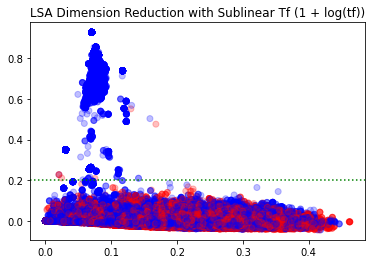

Above  0 Threshold:
count    8917.000000
mean        0.000673
std         0.025933
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: gender, dtype: float64

m_from
pete.davis@enron.com          8908
robert.walker@enron.com          2
monika.causholli@enron.com       2
elizabeth.sager@enron.com        2
lisa.gang@enron.com              1
karen.denne@enron.com            1
j..kean@enron.com                1
dtype: int64

28                                                                    start date hourahead hour hourahead schedule download failed manual intervention required
67        start date hourahead hour no ancillary schedule awarded variance detected variance detected in energy import export schedule variance detected in ...
172                                                                   start date hourahead hour hourahead schedule download failed manual intervention required
185       start date hourahead hour 

In [11]:
%%time
_ = svd_decom(main_df, len(main_df), hline=0.2)

## Remove duplicates above threshold; shuffle, reset df index

In [12]:
select_idx = _[_[1]<.20].index # remove query
main_df = main_df.iloc[select_idx,:]
main_df = main_df.sample(len(main_df),random_state=42).reset_index(drop=True) # shuffle, reset index

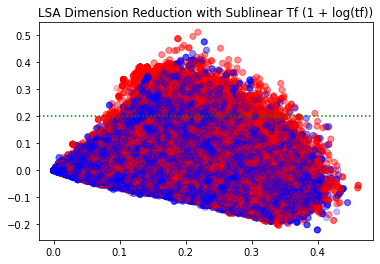

Above  0 Threshold:
count    16779.000000
mean         0.532928
std          0.498929
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: gender, dtype: float64

m_from
debra.perlingiere@enron.com    2709
tana.jones@enron.com           1522
sara.shackleton@enron.com      1335
vince.kaminski@enron.com       1142
kay.mann@enron.com              819
darron.giron@enron.com          520
steven.kean@enron.com           440
eric.bass@enron.com             425
phillip.love@enron.com          414
mark.taylor@enron.com           313
dtype: int64

79                                        debra perlingiere enron north america corp legal department smith street eb houston texas dperlin enron com phone fax
101       to michael walter hou ect ect harry bucalo hou ect ect neal winfree hou ect ect phillip love hou ect ect eric bass hou ect ect matthew lenhart hou...
118       carol st clair eb phone fax carol st clair enron com forwarded 

In [13]:
%%time
_ = svd_decom(main_df, len(main_df), hline=0.2)
#_ = svd_decom(main_df, 1000, hline=0.2)

> We could continue adjusting the threshold to capture more possible duplicates - but this also introduces ***bias*** into our dataset as we try to reduce variability. To avoid too much bias introduced prior to applying the models, we only removed the first significant selection seen above.

## Initial Observations
To extract features from the text, we'll be using **TF-IDF** (Term frequency, Inverse document frequency). This technique leverages the frequency of words across the corpus to reduce the weight of high-frequency words (Think, ***the***), while using the frequency of words within documents and across the corpus to create data *features*.    

Since our current dataset sits around 400k still, we're going to leverage the functionality of `Sklearn`; specifically the `TfIdfVectorizer`.    

Next, we'll transform the data with a `LogisticRegression` model, and extract some quick coefficient scores to compare against our features.

> To blend this process in with our EDA, we're drawing random samples using `pandas.DataFrame.sample` and passing it to our user function. 
>
> Note the `token_pattern` method below; Sklearn's vectorizers (Both Count & TfIdf) accept `regex` patterns for additional Feature selection. Below, the pattern `r"\w{2,}"` is a generic pattern that represents a class of, *'Any two or more **word characters (\w)**. 
>
> The other significant arguments for the `TfIdfVectorizer` seen below are ***min_df*** and ***max_df***. Currently, we're passing their default values as well. *Min_df* can take either an `integer` or a `float` value; when an `integer` is passed, the vectorizer treats it as a word count constant related to document count (i.e. 4 would mean reject any words that appear in less than 4 documents). The `float` is used to set the same lower threshold and can be any `float` between [0, 1]. If a `float` is used, it functions as a percentage of the total corpus (i.e. 1% would reject any words that appear in less than 1% of the entire corpus).
>
> The same structure applies to *max_df*, though it sets the **upper threshold**. 

Below, we'll using the following visual aides to explore our features:
- Histogram, with some logy for scaling;
- ECDF (Empirical Distribution Function); and,
- Scatter plot for comparisons across Coef score, TfIdf, and character count;

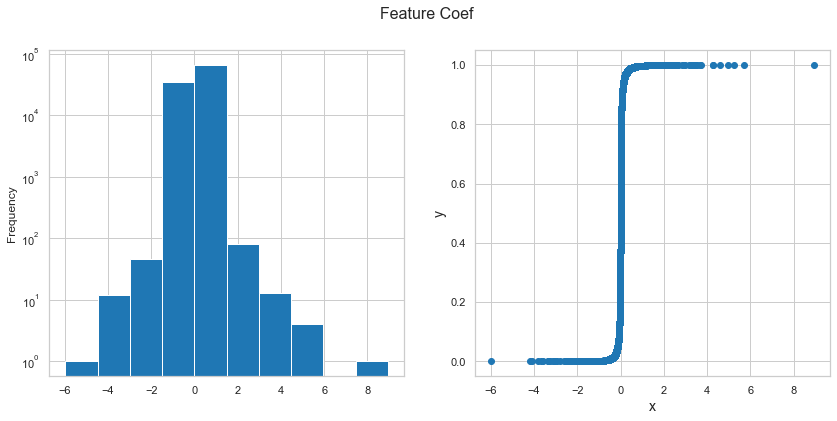

count    101272.000000
mean          0.001888
std           0.166291
min          -5.978644
25%          -0.016909
50%           0.000000
75%           0.011011
max           8.951298
Name: feature_coef, dtype: float64


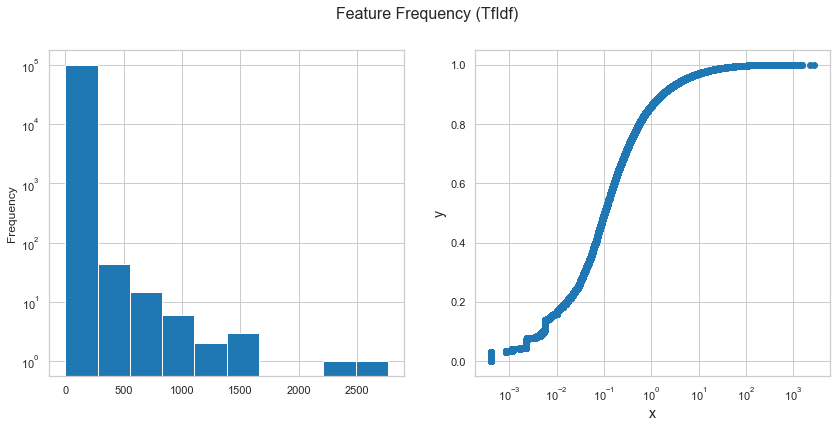

count    101272.000000
mean          2.035270
std          22.326584
min           0.000419
25%           0.028264
50%           0.103257
75%           0.384368
max        2766.923127
Name: feature_frequency, dtype: float64


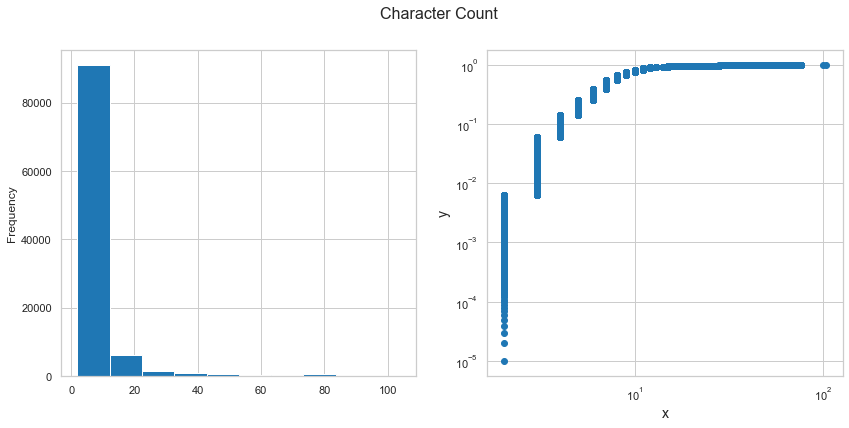

count    101272.000000
mean          9.044237
std           8.886996
min           2.000000
25%           5.000000
50%           7.000000
75%           9.000000
max         104.000000
Name: character_count, dtype: float64


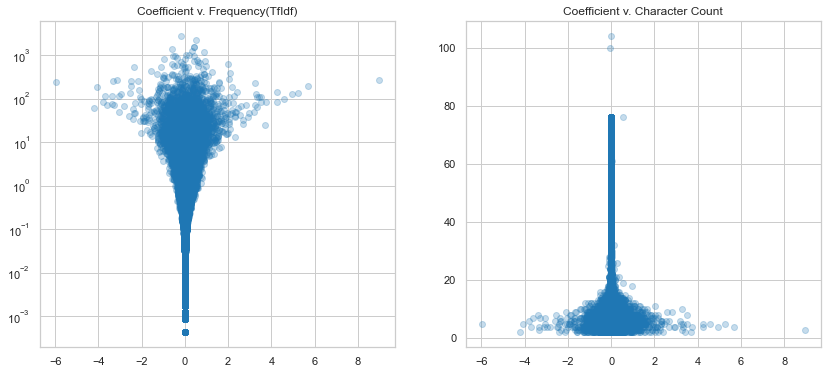

        feature_coef  feature_frequency  character_count
count  101272.000000      101272.000000    101272.000000
mean        0.001888           2.035270         9.044237
std         0.166291          22.326584         8.886996
min        -5.978644           0.000419         2.000000
25%        -0.016909           0.028264         5.000000
50%         0.000000           0.103257         7.000000
75%         0.011011           0.384368         9.000000
max         8.951298        2766.923127       104.000000



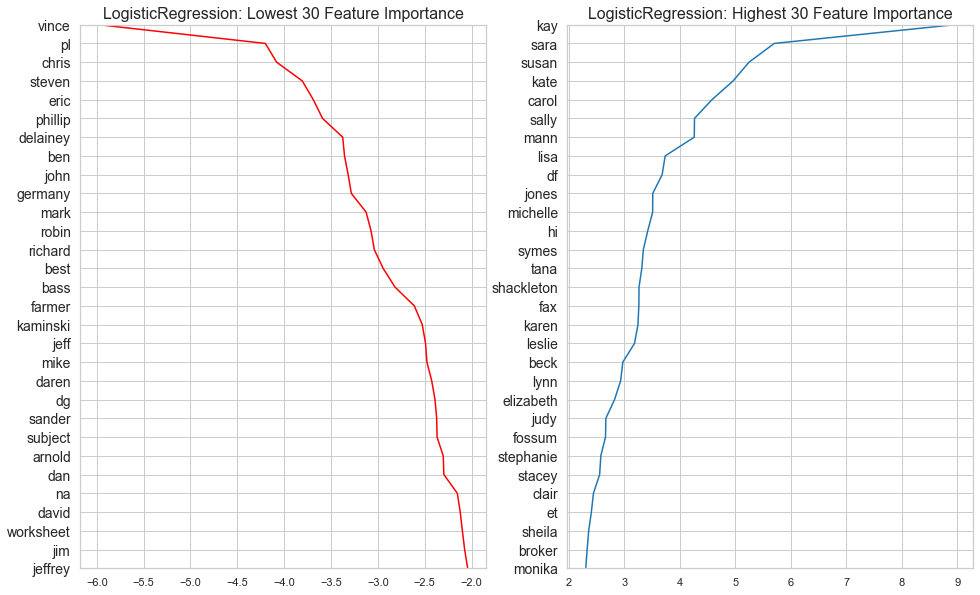


      feature_name  feature_coef  feature_frequency  character_count
48993          kay      8.951298         264.183618                3
79209         sara      5.699563         193.364477                4
86431        susan      5.246271         133.976603                5
48913         kate      4.958632         129.695549                4
15603        carol      4.578278          95.768454                5
78957        sally      4.263448          82.281215                5
55589         mann      4.259483         140.056133                4
53401         lisa      3.734997          82.486192                4
24791           df      3.680666          25.056726                2
47725        jones      3.511799         110.769970                5
58648     michelle      3.509563          84.070809                8
40836           hi      3.420849         108.604615                2
86876        symes      3.341824          65.802527                5
87306         tana      3.314531 

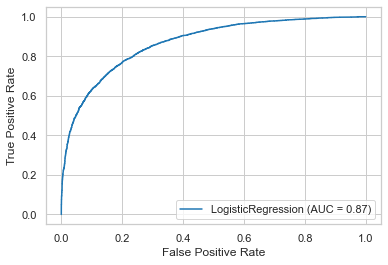

In [15]:
%%time
visualizer(main_df, n=30000, list_n=30, max_iter=500, n_jobs=-1, min_df=1, max_df=1.0, token_pattern=r"\w{2,}", stop_words=None)

**Note:** Our `LogisticRegression` classifier coefficient scores are polarized away from 0. The more a Feature Coefficient score increases (Or decreases) away from 0, the more it correlates with one **target variable or the other.** 

> Since 0 represents ***no feature importance***, `LogisticRegression` is a great resource for **Binary Classification** problems. Here, we'll use it to explore **Feature Selection**, and again when implementing a classifier (Applying our model) in the last stage of this project.

We're exploring two attributes of the features:
- Frequency; and, 
- Character Count;

Frequency can be acquired from either the `CountVectorizer` or `TfidfVectorizer` by applying the `.fit_transform` method to our data, transforming the data ***into a document-term matrix,*** and *summing the matrix along the 0-axis*. Here's an example of leveraging the `TfidfVectorizer` and `LogisticRegression` functions from the `Sklearn` library to build a DataFrame of each Feature, Frequency, and Coef score:

In [ ]:
def feature_coef_count(X):
    """Transforms feature data into a term frequency count matrix.
       Feature name, frequency is extracted from vectorizer. After,
       Logr model is fit to the term matrix and a coef score is returned."""
    from sklearn.feature_extraction.text import TfidfVectorizer
    vect = TfidfVectorizer(use_idf=False, smooth_idf=False)
    X = vect.fit_transform(X)
    import numpy as np
    feature_count = X.toarray()
    feature_count = np.sum(feature_count, 0)
    feature_name = vect.get_feature_names()

    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression().fit(X, y)
    feature_coef = model.coef_[0]

    _ = pd.DataFrame(zip(feature_name, feature_coef, feature_count))
    _.columns = ['feature_name', 'feature_score', 'feature_count']
    _['character_count'] = _.feature_name.str.count('[A-aZ-z]')

    return _

> Note: This approach fits a model to **a term frequency matrix,** not the **term frequency, inverse document frequency**. In this project, the difference between using feature frequency (i.e. count) and TfIdf came down to memory space - The TfIdf reduction allowed for bigger observation samples. 
>
> It is useful to know that ***count vectorization is costly*** with respect to memory - reducing the sample size that can be drawn significantly. In one case, a 40,000 point sample had to be reduced to around 10,000 due to the memory size requirement of the count matrix.

## Feature Selection Overview
Along with using Dimension Reduction + TfIdf to search for duplicates and learning how costly count vectorization can be for *EDA*, some other interesting insights from the `03_feature_selection.ipynb` notebook are:
- How useful the ECDF plot is when approximating thresholds;
- Leveraging the power of visuals to easily identify extreme values/outliers (Like 30+ character 'words'); and,
- The efficiency of using the Sklearn function's functionality

# IV. Model Implementation
To address our **Binary Classification** problem, we'll be using the Scikit-learn (Sklearn, vers 0.23.1) library primarily, with pandas and numpy to assist with data manipulation. Also, we'll be using the standard NLTK stop words list.

### Library version

In [2]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.5.
The scikit-learn version is 0.23.1.


In [7]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{"isn't", 'so', 're', 'do', 'more', 'isn', 'weren', 'themselves', 'only', 'too', "aren't", 's', 'further', 'against', 'the', 'hers', 'these', 'on', 'your', 'herself', "should've", 'as', 'o', 'hadn', 'were', 'than', 'again', 'up', 'by', "she's", 'shouldn', 'such', 'm', 'but', 'himself', 'both', 'over', 'few', 'them', 'ma', 'yourselves', 've', 'during', "haven't", 'here', 'above', 'you', 'was', 'while', 'if', 'all', 'my', 'couldn', 'about', 'we', 'out', 'doing', 'very', 'aren', "weren't", 'itself', 'doesn', 'below', 'until', 'me', 'down', "that'll", "mightn't", 'had', 'which', 'some', 'a', "you'd", 'other', "needn't", 'once', 'in', 'there', "mustn't", 't', 'those', 'to', 'have', 'of', 'before', 'don', "wasn't", 'off', 'haven', 'mightn', "hadn't", 'from', 'is', 'd', "don't", "shan't", "it's", 'because', 'didn', 'when', 'just', 'he', 'yours', 'his', 'then', "you're", 'this', 'they', 'where', 'through', 'myself', 'theirs', 'will', 'does', 'hasn', 'needn', 'own', "won't", 'any', 'mustn', 'in

## Evaluate Classifiers
The initial 6 models are evaluated across 6 iterations of 5 levels of Cross-Validation, with randomized sampling each iteration. Models are evaluated on the metric **accuracy**, as target data is ~ 55/45% split. All modeling in this section was used with a 60/40 train/test split. Random state 42 was used when applicable, and sampling was randomized by passing the dataframe to `pandas.DataFrame.sample()`, then resetting the index.

The models are:
- KNeighborsClassifier;
- LinearSVC;
- LogisticRegression;
- MultinomialNB;
- RandomForestClassifier; and,
- SGDClassifier;

Of these, 3 models were selected and retested with varying sample sizes.

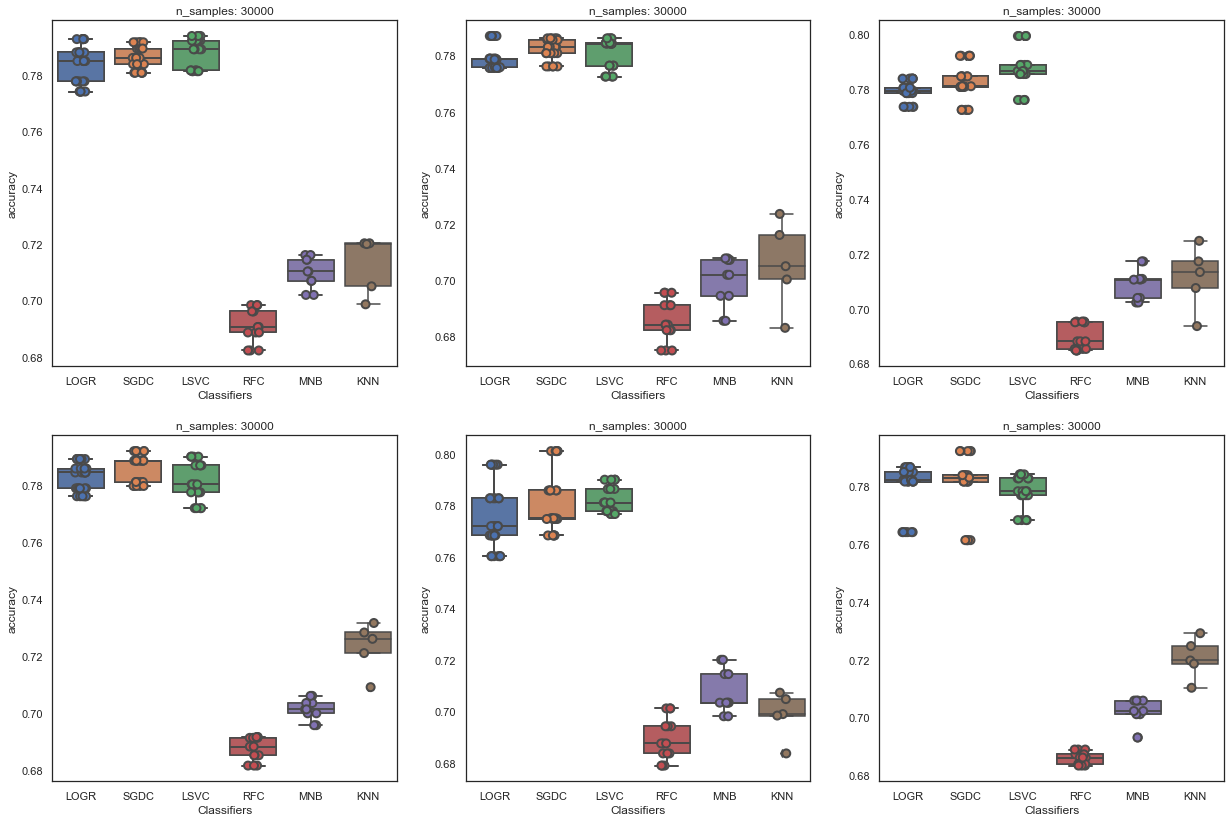

Wall time: 2min 47s


In [10]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
iter_ct = 6
iter_this = np.linspace(1,iter_ct,iter_ct)

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

run_these = ['RFC','LSVC','MNB','LOGR','SGDC','KNN']

plt.figure(figsize=(21,14), facecolor='w', edgecolor='k')
for x in iter_this:
    plt.subplot(2, 3, x)
    plot_multi(main_df, n_samples=30000, run_these=run_these)
    main_df = resample_frame(main_df)
plt.show()

## Evaluate Classifiers, Add Sample Variation
Three models were selected based on performance to be reevaluated, including sample variation. Sample intervals were evenly spaced between 60,000 and the full dataset across 6 iterations. Models included:
- LinearSVC;
- LogisticRegression; and, 
- SGDClassifier;

As seen below, both the **LinearSVC (LSVC)** and **LogisticRegression (LOGR)** improved overall accuracy over the improvement made by the SGDC classifier. These two models were selected for parameter optimization because of this, and because they are seen as **robust models for binary classification.**

[ 60000 128160 196320 264481 332641 400802]


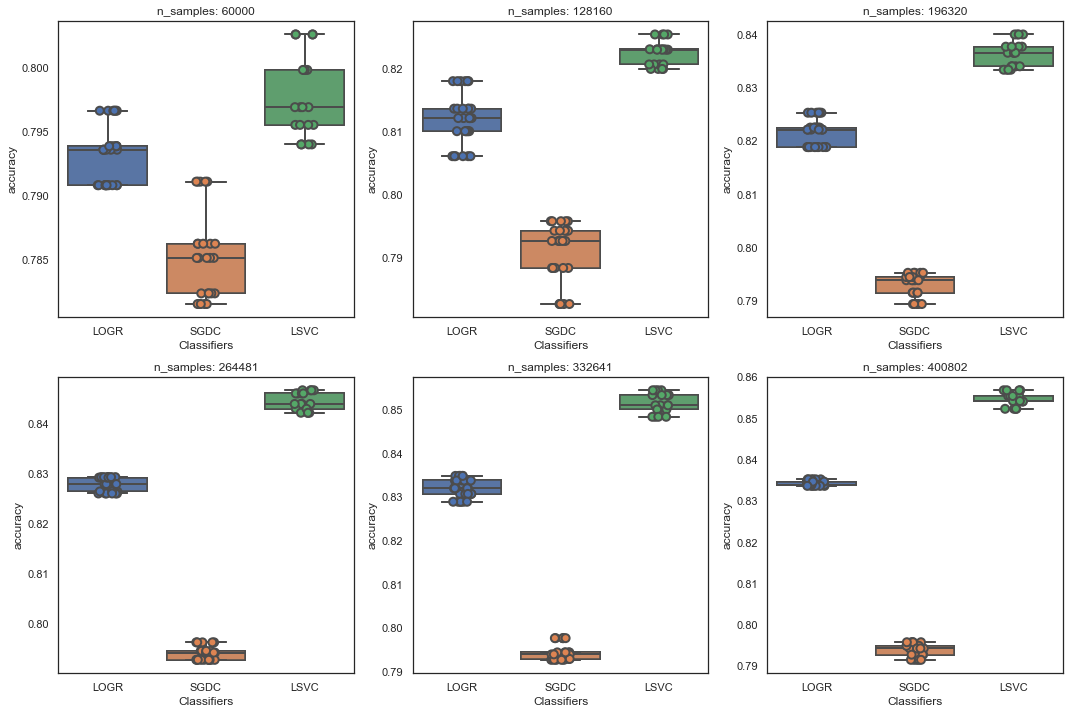

Wall time: 6min 36s


In [11]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
iter_ct = 6
iter_this = np.linspace(1,iter_ct,iter_ct)

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

run_these = ['LSVC','LOGR','SGDC']

sample_nums = np.linspace(60000, len(main_df), iter_ct).astype('int32')
#sample_nums = np.linspace(4000, 11000, iter_ct).astype('int32')
print(sample_nums)
x=1
plt.figure(figsize=(18,12), facecolor='w', edgecolor='k')
for sample_count in sample_nums:
    plt.subplot(2, 3, x)
    plot_multi(main_df, n_samples=sample_count, run_these=run_these)
    main_df = resample_frame(main_df)
    x+=1
plt.show()

## Tuning parameters on LinearSVC
The full code for this section of the project can be reviewed in the notebook `04.01_model_implementation`.    

The lsvc model was optimized on the `C` parameter across a range of [ 0.1,  1.,  5., 7.5, 10.], with `max_iter` set to 5000. The model was tuned using Sklearn's `GridSearchCV` with 10 iterations and input randomized 180,000 samples.
    
TfIdf was used to transform the Feature dataset with the following parameters:
- min_df: 0.01;
- max_df: 0.99;
- stop_words from the NLTK library; and,
- Token pattern restricting word length between 3 & 15 characters;

In [13]:
%%time
lsvc_best = lsvc_gridsearchcv(main_df, n=180000)

Tuned LSVC Parameters: {'lsvc__C': 1.0, 'lsvc__max_iter': 5000, 'vect__max_df': 0.99, 'vect__min_df': 0.01, 'vect__stop_words': {"isn't", 'so', 're', 'do', 'more', 'isn', 'weren', 'themselves', 'only', 'too', "aren't", 's', 'further', 'against', 'the', 'hers', 'these', 'on', 'your', 'herself', "should've", 'as', 'o', 'hadn', 'were', 'than', 'again', 'up', 'by', "she's", 'shouldn', 'such', 'm', 'but', 'himself', 'both', 'over', 'few', 'them', 'ma', 'yourselves', 've', 'during', "haven't", 'here', 'above', 'you', 'was', 'while', 'if', 'all', 'my', 'couldn', 'about', 'we', 'out', 'doing', 'very', 'aren', "weren't", 'itself', 'doesn', 'below', 'until', 'me', 'down', "that'll", "mightn't", 'had', 'which', 'some', 'a', "you'd", 'other', "needn't", 'once', 'in', 'there', "mustn't", 't', 'those', 'to', 'have', 'of', 'before', 'don', "wasn't", 'off', 'haven', 'mightn', "hadn't", 'from', 'is', 'd', "don't", "shan't", "it's", 'because', 'didn', 'when', 'just', 'he', 'yours', 'his', 'then', "you'r

## Fitting LinearSVC with best parameters
The model was then fit with the tuned C value, 1.0, along with the other previous parameters to a 60/40 train/test of the entire dataset - returning the `classification_report` and `roc_curve` below.

[[77687 13060]
 [22685 46889]]
              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81     90747
         1.0       0.78      0.67      0.72     69574

    accuracy                           0.78    160321
   macro avg       0.78      0.77      0.77    160321
weighted avg       0.78      0.78      0.77    160321

Wall time: 1min


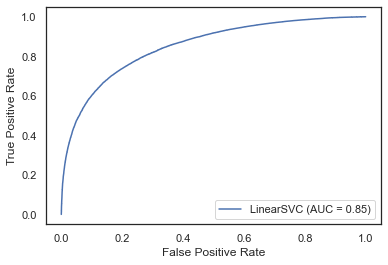

In [14]:
%%time
vect, model, X = lsvc_best_run(lsvc_best, len(main_df))

## Tuning, fitting with LogisticRegression
The LogisticRegression `C` parameter was tuned with 5 logspace points across the range [-5, 8], and the `solver` parameter between the default `lbfgs` and `saga` solvers. Tuned parameters were also fit to the entire dataset using a 60/40 train/test split to evaluate relative metrics between the two models.

In [17]:
%%time
logreg_best = logreg_gridsearchcv(main_df, n=180000)

Tuned Logreg Parameters: {'logreg__C': 31.622776601683793, 'logreg__max_iter': 1000, 'logreg__solver': 'saga', 'vect__max_df': 0.99, 'vect__min_df': 0.01, 'vect__stop_words': {"isn't", 'so', 're', 'do', 'more', 'isn', 'weren', 'themselves', 'only', 'too', "aren't", 's', 'further', 'against', 'the', 'hers', 'these', 'on', 'your', 'herself', "should've", 'as', 'o', 'hadn', 'were', 'than', 'again', 'up', 'by', "she's", 'shouldn', 'such', 'm', 'but', 'himself', 'both', 'over', 'few', 'them', 'ma', 'yourselves', 've', 'during', "haven't", 'here', 'above', 'you', 'was', 'while', 'if', 'all', 'my', 'couldn', 'about', 'we', 'out', 'doing', 'very', 'aren', "weren't", 'itself', 'doesn', 'below', 'until', 'me', 'down', "that'll", "mightn't", 'had', 'which', 'some', 'a', "you'd", 'other', "needn't", 'once', 'in', 'there', "mustn't", 't', 'those', 'to', 'have', 'of', 'before', 'don', "wasn't", 'off', 'haven', 'mightn', "hadn't", 'from', 'is', 'd', "don't", "shan't", "it's", 'because', 'didn', 'when

[[77196 13551]
 [21915 47659]]
              precision    recall  f1-score   support

         0.0       0.78      0.85      0.81     90747
         1.0       0.78      0.69      0.73     69574

    accuracy                           0.78    160321
   macro avg       0.78      0.77      0.77    160321
weighted avg       0.78      0.78      0.78    160321



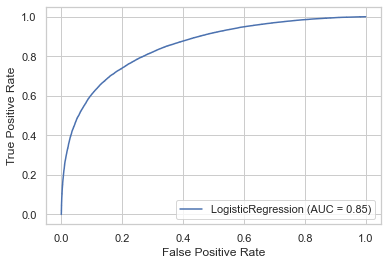

In [18]:
vect, model, X = logreg_best_run(logreg_best, n=len(main_df))

**Both of our models** returned a noticably weak recall value for the smaller Feature variable. **Recall** is calculated by taking the number of **True Positives**, and dividing it by a combined value: *The sum of True Positives and False Negatives*. 

**True Positives** are the labels from the that the model classified as in the *positive class* that are in the *positive class*. In other words, the model predicted 1 and the answer was 1.

**False Negatives** are labels that the model classified as *negative* but were actually *positive*. The model predicted 0 but the answer was 1. Another way to conceptualize recall is thinking of it with respect to murder suspects in a lineup. Falsely accusing one of the innocent men on the line up could be seen as a false negative.

For the test set, the data was split roughly 57/43 - so a slight imbalance but indicative of the population. To remedy this, we should take the models and apply the more robust **Cross Validation** and see how the score changes.

## 100 Features from LinearSVC
Below are the highest and lowest 100 features from the tuned LinearSVC fit. Our low range is the **boy** class, and the high range is our **girl** class.

Like we observed in our previous Feature analysis, a majority of the features are first names (For both classes).

There are subtle differences in the tone of some of the words as well; though it might be reader-bias. On the left, there are a noticable amount of powerful, positive, or authority-related words: *dissemination, operator, player, best, acceptable, strictly, approve, identified, acceptance, association, concerned, concerning.*

One the right are less aggressive, authority, or positive words: *missing, copying, assistant, reminder.* 

Though this assumption is guilty of retroactive bias, the ultra-male, big-ego culture Enron was known to have might be present across the feature tone - and overall less number of emails sent. It might also be reflective of women preferring face-to-face or personal communication options over the coldness of an email.

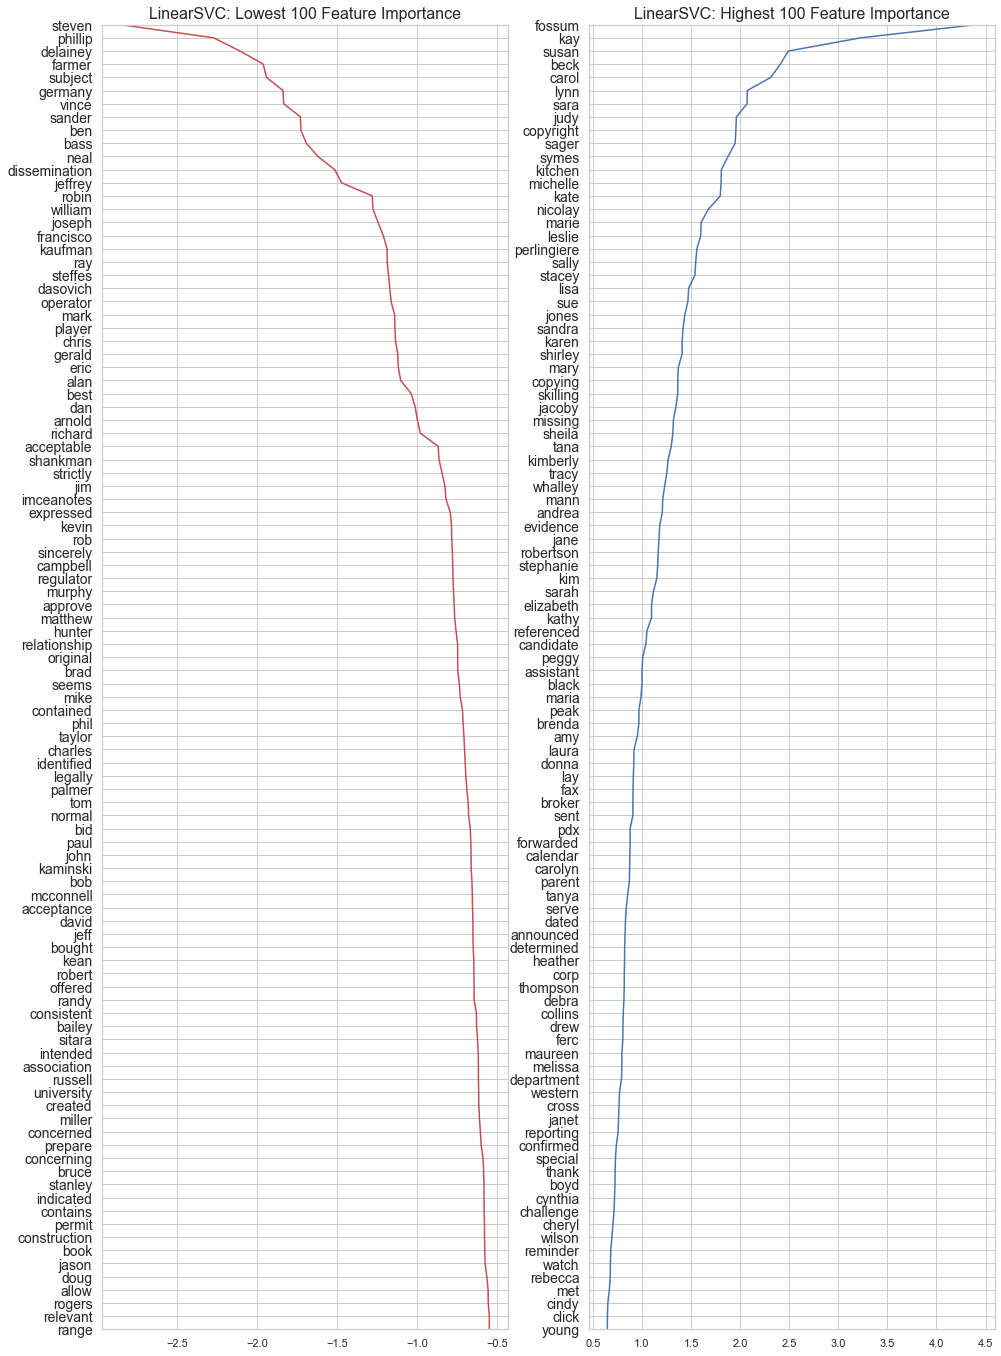


     feature_name  feature_score
523        fossum       4.406103
696           kay       3.228284
1311        susan       2.492257
137          beck       2.410237
205         carol       2.312676
...           ...            ...
1074      rebecca       0.677228
821           met       0.668437
232         cindy       0.652928
241         click       0.648533
1482        young       0.648165

[100 rows x 2 columns]

     feature_name  feature_score
1281       steven      -2.855919
968       phillip      -2.272935
354      delainey      -2.108218
484        farmer      -1.963336
1294      subject      -1.943100
...           ...            ...
397          doug      -0.566243
42          allow      -0.558264
1150       rogers      -0.557181
1100     relevant      -0.550563
1062        range      -0.550459

[100 rows x 2 columns]



In [15]:
visualizer(vect, model, X, list_n=100)

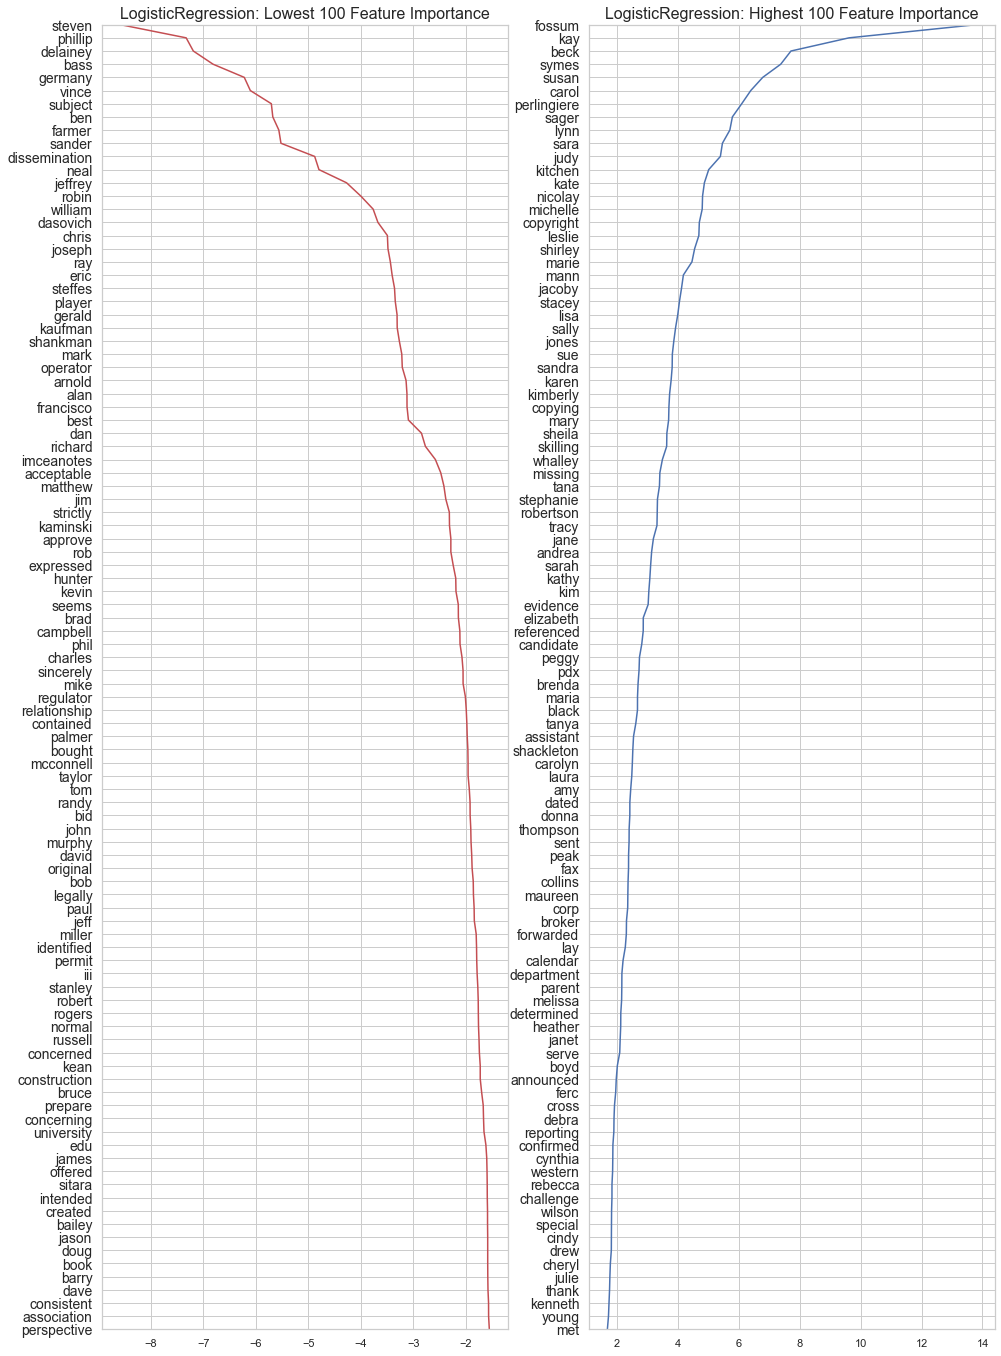


     feature_name  feature_score
523        fossum      13.797006
696           kay       9.622840
137          beck       7.717132
1314        symes       7.382228
1311        susan       6.791782
...           ...            ...
688         julie       1.777976
1343        thank       1.767065
702       kenneth       1.749025
1482        young       1.732224
821           met       1.695736

[100 rows x 2 columns]

     feature_name  feature_score
1281       steven      -8.582274
968       phillip      -7.328879
354      delainey      -7.192673
136          bass      -6.816980
551       germany      -6.221389
...           ...            ...
132         barry      -1.580837
338          dave      -1.577100
281    consistent      -1.566213
105   association      -1.565388
964   perspective      -1.551669

[100 rows x 2 columns]



In [19]:
visualizer(vect, model, X, list_n=100)

## Reflection

We were able to observe an efficiency tradeoff between *sample input* and *accuracy score* around 190,000 samples. We also found creative ways to use model features and access additional insight during our EDA, feature selection, and modeling. The biggest boon is the experience gained by applying the Sklearn library across multiple models and stages of the modeling process. 

To **improve model performance,** we can apply Cross Validation to the tuned parameter fit. We can also **expand parameter tuning with a RandomSearch** function. There are many options for improving the Feature selection in this project as well; for example, many methods of **subset selection** are available. Binary classification, itself, is a broad spectrum of useful applications that this project did not begin to exhaust.
    
Continuing forward, an interesting next step for this project would be to investigate past the, ***'First-Name Feature,'*** barrier. Because email addresses (And subsequently, names) were used to label the emails with a gender, **there is probably a strong bias introduced by the process of data collection that would require further investigation**. There are other variables available to consider for expanding analysis as well; communication patterns between social contacts or along certain times might be explored with the Enron email dataset.